# Original version:
- Dataset: Iris
- Model: l2 linear regression
- parallel: 3 parallel engines and controller in the same laptop

In [1]:
import ipyparallel as ipp
import numpy as np
import time

In [2]:
c = ipp.Client()
#create a directview
dview = c[:]

In [3]:
c.ids

[0, 1, 2]

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
train = iris.data
target = iris.target

In [5]:
#sending date to engines
c[0]['X'] = train[:50]
c[1]['X'] = train[50:100]
c[2]['X'] = train[100:150]

c[0]['y'] = target[:50]
c[1]['y'] = target[50:100]
c[2]['y'] = target[100:150]

In [6]:
#Algorithm 2 - line 7, retrieve w and c from aggregator 
def wc_from_eng(engine):
    w = []
    c = []
    for i in range(len(engine.ids)):
        w.append(engine[i]['lr.get_coef()'])
        c.append(engine[i]['lr.Est_Resource()']) 
    return w,c

In [7]:
#Algorithm 2 - line 8, global parameter updata according to (5)
data_size = np.array([150,150,150])
def global_update(w_local,data_size):
    temp = 0
    for i in range(len(w_local)):
        temp = temp + w_local[i] * data_size[i]
    return temp/data_size.sum()
        

In [8]:
#retrieve belta and grad to aggregator #Algorithm 2 - line 14
def bg_from_eng(engine):
    belta = []
    grad = []
    for i in range(len(engine.ids)):
        belta.append(engine[i]['lr.belta'])
        grad.append(engine[i]['lr.grad_t0']) 
    return belta,grad

In [9]:
#Algorithm 2 - line 15
def belta_update(belta_local,data_size):
    temp = 0
    for i in range(len(belta_local)):
        temp = temp + np.array(belta_local[i]) * data_size[i]
    return temp/data_size.sum()

In [10]:
#Algorithm 2 - line 16
def grad_update(grad_local,data_size):
    temp = 0
    for i in range(len(grad_local)):
        temp = temp + np.array(grad_local[i]) * data_size[i]
    return temp/data_size.sum()

def delta_update(local_grad, grad_aggregator, data_size):
    delta_local = []
    local_grad = np.array(local_grad) 
    grad_aggregator = np.array(grad_aggregator)
    for item in local_grad:
        temp_delta = np.linalg.norm(item - grad_aggregator)
        delta_local.append(temp_delta)
    return belta_update(delta_local,data_size)

In [11]:
#send torque and w to engines from aggregator
def snd_to_eng(w,torque,engine):
    for i in range(len(engine.ids)):
        engine[i]['w_aggregator'] = w
        engine[i]['torque_aggregator'] = torque[i]

In [12]:
#Algorithm 2 - line 17, binary search for new torque
def G(torque, delta, belta, eta, phi):
    h = delta* (pow((eta*belta + 1),torque)-1)/belta - eta*delta*torque
    G = torque*(eta*(1-belta*eta/2)-phi*h/torque)
    return G

def binary_search(torque,delta, belta, gamma,phi,eta = 0.0001):
    upper_bound = int(gamma * torque)
    G_list = []
    for i in range(upper_bound):
        torque_try = i + 1
        G_list.append(G(torque_try, delta, belta, eta, phi))
    torque_star = np.argmax(np.array(G_list)) + 1
    return torque_star, G_list

In [13]:
import numpy as np
import time

def compute_loss(w, feature, target):
    m = len(target)
    sum_of_square_errors = np.square(np.dot(feature,w)-target).sum()
    cost = sum_of_square_errors/(2*m)
    
    return cost
    

class LinearRegression:

    def __init__(self):
        self.t = 0
        self.t_0 = 0
        self.grad = 0
        self.learning_rate = 0.0001
        self.torque = 0
        self.belta = 0
        self.resource = 0
        self.grad_t0 = 0
        self.history = []
        self.w = 0
        self.w_hat = 0
        self.w_t0 = 0
    def Rec_from_Agg(self, w_global, torque_global):
        self.w_t0 = w_global
        self.w_hat = w_global
        self.torque = torque_global
    def Snd_to_Agg(self):
        if self.t_0 > 0:
            return w,self.resource, self.belta, self.grad_t0
        else:
            return w,self.resource
    def aa(self):
        self.w = self.w_hat
    
    def Est_Resource(self):
        return self.resource

    def get_coef(self):
        return self.w
    
    def set_coef(self, w_global):
        self.w = w_global
        
    def Est_Belta(self ,X, y):
        grad_global_parameter = np.dot((np.dot(X ,self.w_hat)-y), X)# In time t, the gradient of local loss of global parameters
        self.grad_t0 = grad_global_parameter
        self.belta = np.linalg.norm(self.grad - grad_global_parameter)/np.linalg.norm(self.w - self.w_hat)
        
    def time_record(self):
        self.t_0 = self.t
        
    def fit(self, X, y):
        self.w = self.w_hat #updata local w by aggregator 
        
        count = 0
        tic = time.time()
        for i in range(self.torque): 
            
            loss = compute_loss(self.w, X, y)
            self.history.append([loss,str(self.t)])#record loss history from t=1, t=0(w intialization) not included
            
            self.t += 1
            grad = np.dot((np.dot(X,self.w)-y), X) + 0.1*self.w
            self.w = self.w - self.learning_rate * grad
            count += 1
            if count < self.torque:
                self.w_hat = self.w
            elif count == self.torque:
                '''
                #self.grad saved for belta computation. 
                #It denotes in time t(update time), the gradient of local loss of local parameters
                
                '''
                self.grad = grad  
            
            
        toc = time.time()
        self.resource = toc - tic
        
        return self
    
    def predict(self, X):
        
        return np.dot(X, self.w)

In [14]:
lr = LinearRegression()

dview.push(dict(LinearRegression = LinearRegression))
#sending LinearRegression object to engines
dview['lr'] = lr

In [15]:
dview['lr']

In [16]:
import time 
t = 0
s = 0
b = 0 # aggregator consumption
R = 5
gamma = 10
phi = 0.2
w_aggregator = np.zeros(4)
torque_aggregator = [1,1,1]
stop = False
loss_hist = []
while True:
    tic = time.time()
    snd_to_eng(w_aggregator,torque_aggregator,c)
    loss = compute_loss(w_aggregator,train,target)
    loss_hist.append(loss)
    print ('%d iteration and loss is: %f'%(t,loss))
    t_0 = t
    t = t + torque_aggregator[0]
    dview.execute("""
import numpy as np
import time    
lr.Rec_from_Agg(w_aggregator, torque_aggregator)
lr.time_record()
if lr.t > 0:
    lr.Est_Belta(X,y)
lr.fit(X,y)
    """)
    
    
    w_local, c_local = wc_from_eng(c)
    #calculate local consumption per iteration
    c_per = np.array(c_local)/torque_aggregator[0]
    w_aggregator = global_update(w_local, data_size)
    if stop:
        w_final = w_aggregator
        break
    #c_local.sum() equal to c*t
    s = s + np.array(c_local).sum()+ b
    
    if t_0 > 0:
        belta_local, grad_local = bg_from_eng(c)
        belta_aggregator = belta_update(belta_local,data_size)
        grad_aggregator = grad_update(grad_local,data_size)
        delta_aggregator = delta_update(grad_local, grad_aggregator, data_size)
        torque_update, G_list = binary_search(torque_aggregator[0], delta_aggregator, belta_aggregator, gamma, phi)
        torque_aggregator = [torque_update for i in range(len(c.ids))]
        print('New torque is:',torque_aggregator[0])
    
    toc = time.time()
    b = toc - tic
    temp = s + torque_aggregator[0]*c_per.sum() + b
    if temp >= R:
        torque_max = (R-b-s)/c_per.sum()
        G_list = np.array(G_list)
        G_min = G_list.min()
        for i, item in enumerate(G_list):
            if item >= torque_max:
                itme = G_min
        torque_updata = np.argmax(G_list) + 1
        torque_aggregator = [torque_update for i in range(len(c.ids))]
        stop = True 

0 iteration and loss is: 0.833333
1 iteration and loss is: 0.833333


C:\Users\wenbi\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


New torque is: 1
2 iteration and loss is: 0.833333
New torque is: 1
3 iteration and loss is: 0.833333
New torque is: 1
4 iteration and loss is: 0.833333
New torque is: 1
5 iteration and loss is: 0.833333
New torque is: 1
6 iteration and loss is: 0.833333
New torque is: 1
7 iteration and loss is: 0.833333
New torque is: 1
8 iteration and loss is: 0.833333
New torque is: 1
9 iteration and loss is: 0.833333
New torque is: 1
got unknown result: bc5c6aa1-a188e45ae65611dafd3483c710 iteration and loss is: 0.833333

New torque is: 1
11 iteration and loss is: 0.833333
got unknown result: 1b7c3ff7-a43668cef24e05037a0f329f
New torque is: 1
12 iteration and loss is: 0.833333
New torque is: 1
13 iteration and loss is: 0.833333
New torque is: 1
14 iteration and loss is: 0.833333
New torque is: 1
15 iteration and loss is: 0.833333
New torque is: 1
16 iteration and loss is: 0.833333
New torque is: 1
17 iteration and loss is: 0.833333
New torque is: 1
18 iteration and loss is: 0.833333
New torque is: 1

C:\Users\wenbi\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
dview['lr.w']

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]

In [38]:
import matplotlib.pyplot as plt

In [41]:
x = np.arange(36)

# Conclusion:
- With a resource budget of 5 seconds, the aggregator totally ran 36 iterations and got loss of 0.097
- The figure below illustrate the loss comparison between parallel computing and global computing of 36 iterations


# Future work:
- Try parallel computing with other engines and CPUs that connected by wifi.
- Try other machine learning algorithm such as SVM and NN.

Text(0,0.5,'Loss')

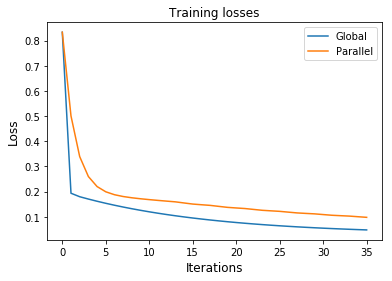

In [50]:
fig, ax = plt.subplots()
plt.plot(x,lr1.history,label='Global')
plt.plot(x,loss_hist,label='Parallel')
ax.legend()
ax.set_title('Training losses')
ax.set_xlabel('Iterations',fontsize = 12)
ax.set_ylabel('Loss', fontsize = 12)


In [26]:
class LinearRegression_test:

    def __init__(self):
        self.t = 0
        self.t_0 = 0
        self.grad = 0
        self.learning_rate = 0.0001
        self.torque = 0
        self.belta = 0
        self.resource = 0
        self.grad_t0 = 0
        self.history = []
        self.w = 0
    def fit(self, X, y):
        for i in range(self.torque):            
            loss = compute_loss(self.w, X, y)
            self.history.append(loss)#record loss history from t=1, t=0(w intialization) not included
            self.t += 1
            grad = np.dot((np.dot(X,self.w)-y), X) + 0.1*self.w
            self.w = self.w - self.learning_rate * grad
        
        return self
    
    def predict(self, X):
        
        return np.dot(X, self.w)